<a href="https://colab.research.google.com/github/John1495/RNA-3D/blob/main/Rna_Multimodel_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install torch torch-geometric egnn-pytorch pandas scikit-learn matplotlib seaborn


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

Epoch 1/5, Loss: 0.7141
Epoch 2/5, Loss: 0.7357
Epoch 3/5, Loss: 0.7397
Epoch 4/5, Loss: 0.7442
Epoch 5/5, Loss: 0.7492
Epoch 1/5, Loss: 0.7014
Epoch 2/5, Loss: 0.7411
Epoch 3/5, Loss: 0.7468
Epoch 4/5, Loss: 0.7530
Epoch 5/5, Loss: 0.7578
GCN RMSE: 1.0229, TM-Score: 0.9984
GAT RMSE: 1.0148, TM-Score: 0.9984


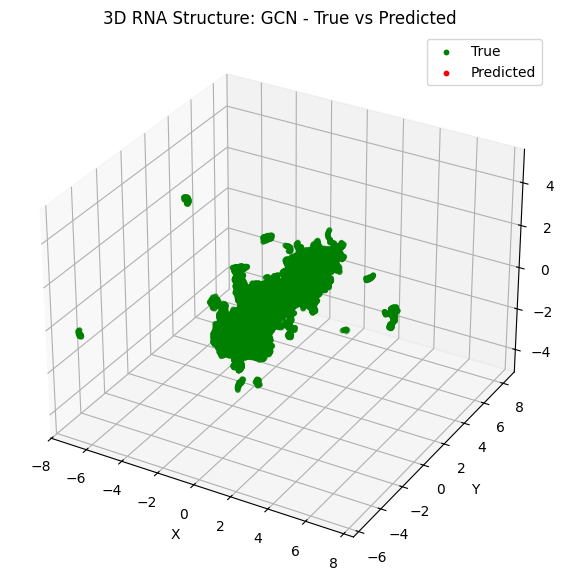

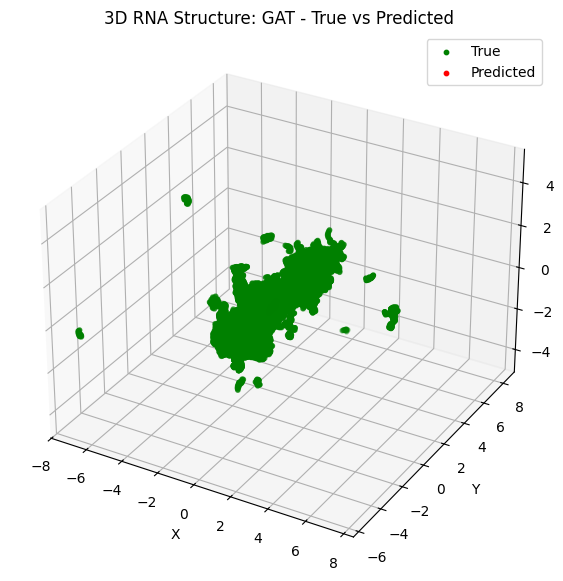

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# =======================
# LOAD AND PREPROCESS DATA
# =======================
seq_df = pd.read_csv('/kaggle/cleaned_train_sequences2 (1).csv')
label_df = pd.read_csv('/kaggle/train_labels1.csv')

# Extract base from resname and clean
label_df['resname'] = label_df['resname'].str.extract(r'([AUGC])')
label_df = label_df.dropna(subset=['resname'])
label_df['target_id'] = label_df['ID'].str.extract(r'(.+)_\d+')

# Compute sequence lengths and filter
seq_df['seq_length'] = seq_df['sequence'].apply(len)
max_length = 800
filtered_seq_df = seq_df[seq_df['seq_length'] <= max_length]

# Merge with label data
merged = pd.merge(label_df, filtered_seq_df[['target_id', 'sequence']], on='target_id', how='inner')

# Filter complete structures (more than 10 residues)
complete_ids = merged.groupby('target_id')['resid'].count()
valid_ids = complete_ids[complete_ids > 10].index
merged = merged[merged['target_id'].isin(valid_ids)]

# Scale 3D coordinates
if not merged[['x_1', 'y_1', 'z_1']].empty:
    scaler = StandardScaler()
    scaler.fit(merged[['x_1', 'y_1', 'z_1']])
else:
    raise ValueError("Coordinates data is empty, please check your input data.")

# =======================
# GRAPH CONSTRUCTION
# =======================
residue_mapping = {'A': 0, 'U': 1, 'G': 2, 'C': 3}

def create_graph_from_group(df_group):
    df_group = df_group.sort_values('resid')
    node_features = torch.eye(4)[[residue_mapping[r] for r in df_group['resname']]]
    coords = df_group[['x_1', 'y_1', 'z_1']].values
    coords = scaler.transform(coords)
    pos = torch.tensor(coords, dtype=torch.float)
    y = pos
    n = len(df_group)
    edge_index = torch.tensor(
        [[i, i+1] for i in range(n-1)] + [[i+1, i] for i in range(n-1)],
        dtype=torch.long
    ).t().contiguous()
    return Data(x=node_features, edge_index=edge_index, pos=pos, y=y)

# Create PyG Data objects
train_graphs = []
for tid in valid_ids:
    g = create_graph_from_group(merged[merged['target_id'] == tid])
    train_graphs.append(g)
train_loader = DataLoader(train_graphs, batch_size=1)

# =======================
# GNN MODELS
# =======================
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim)
        self.conv2 = GATConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# =======================
# TRAINING LOOP
# =======================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gcn_model = GCN(input_dim=4, hidden_dim=32, output_dim=3).to(device)
gat_model = GAT(input_dim=4, hidden_dim=32, output_dim=3).to(device)

def train_model(model, loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            loss = F.mse_loss(output, batch.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(loader):.4f}')

gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.001)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.001)

train_model(gcn_model, train_loader, gcn_optimizer, epochs=5)
train_model(gat_model, train_loader, gat_optimizer, epochs=5)

# =======================
# EVALUATION
# =======================
def evaluate_model(model, loader):
    model.eval()
    predictions, true = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred_coords = model(batch)
            predictions.append(pred_coords.cpu().numpy())
            true.append(batch.y.cpu().numpy())
    predictions = np.concatenate(predictions, axis=0)
    true = np.concatenate(true, axis=0)
    return predictions, true

def calculate_rmse(true, pred):
    return np.sqrt(mean_squared_error(true, pred))

def compute_tm_score(true_coords, pred_coords):
    assert true_coords.shape == pred_coords.shape
    L = true_coords.shape[0]
    d0 = max(1.24 * ((L - 15) ** (1/3)) - 1.8, 0.5)
    distances = np.linalg.norm(true_coords - pred_coords, axis=1)
    tm_score = np.sum(1 / (1 + (distances / d0) ** 2)) / L
    return tm_score

# Evaluate GCN
gcn_preds, gcn_true = evaluate_model(gcn_model, train_loader)
gcn_rmse = calculate_rmse(gcn_true, gcn_preds)
gcn_tm = compute_tm_score(gcn_true, gcn_preds)

# Evaluate GAT
gat_preds, gat_true = evaluate_model(gat_model, train_loader)
gat_rmse = calculate_rmse(gat_true, gat_preds)
gat_tm = compute_tm_score(gat_true, gat_preds)

# Print results
print(f"GCN RMSE: {gcn_rmse:.4f}, TM-Score: {gcn_tm:.4f}")
print(f"GAT RMSE: {gat_rmse:.4f}, TM-Score: {gat_tm:.4f}")

# =======================
# PLOTTING
# =======================
def plot_predictions(true, predictions, model_name):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(true[:, 0], true[:, 1], true[:, 2], c='g', label='True', s=10)
    ax.scatter(predictions[:, 0], predictions[:, 1], predictions[:, 2], c='r', label='Predicted', s=10)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'3D RNA Structure: {model_name} - True vs Predicted')
    ax.legend()
    plt.show()

plot_predictions(gcn_true, gcn_preds, 'GCN')
plot_predictions(gat_true, gat_preds, 'GAT')


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

GCN Validation RMSE: 1.025572203044938
GAT Validation RMSE: 1.0204343340398148
GCN TM-Score: 0.9955487847328186
GAT TM-Score: 0.9956499338150024


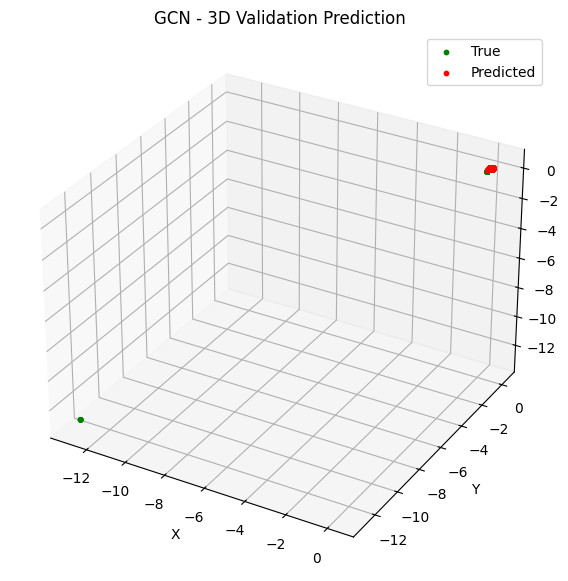

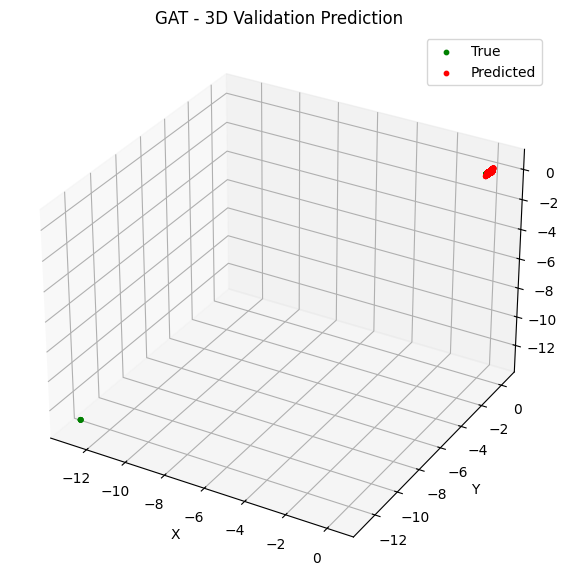

In [36]:
import torch
import pandas as pd
import numpy as np
from torch_geometric.data import Data, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load validation data
val_seq_df = pd.read_csv('/kaggle/validation_sequences.csv')
val_label_df = pd.read_csv('/kaggle/validation_labels.csv')

# Preprocess labels
val_label_df['resname'] = val_label_df['resname'].str.extract(r'([AUGC])')
val_label_df = val_label_df.dropna(subset=['resname'])
val_label_df['target_id'] = val_label_df['ID'].str.extract(r'(.+)_\d+')

# Merge sequences with labels
val_merged = pd.merge(val_label_df, val_seq_df[['target_id', 'sequence']], on='target_id', how='left')

# Compute sequence lengths and filter
val_lengths = val_merged.groupby('target_id')['resid'].count()
val_filtered_ids = val_lengths[(val_lengths > 10) & (val_lengths <= 800)].index
val_merged = val_merged[val_merged['target_id'].isin(val_filtered_ids)]

# Use the same residue encoding and scaler from training
residue_mapping = {'A': 0, 'U': 1, 'G': 2, 'C': 3}
scaler = StandardScaler()
scaler.fit(val_merged[['x_1', 'y_1', 'z_1']])  # Or reuse training scaler if saved

def create_graph_from_group(df_group):
    df_group = df_group.sort_values('resid')
    node_features = torch.eye(4)[[residue_mapping[r] for r in df_group['resname']]]
    coords = df_group[['x_1', 'y_1', 'z_1']].values
    coords = scaler.transform(coords)
    pos = torch.tensor(coords, dtype=torch.float)
    y = pos
    n = len(df_group)
    edge_index = torch.tensor([[i, i+1] for i in range(n-1)] + [[i+1, i] for i in range(n-1)], dtype=torch.long).t().contiguous()
    return Data(x=node_features, edge_index=edge_index, pos=pos, y=y)

# Create validation graphs
val_graphs = []
for tid in val_filtered_ids:
    g = create_graph_from_group(val_merged[val_merged['target_id'] == tid])
    val_graphs.append(g)
val_loader = DataLoader(val_graphs, batch_size=1)

# Load trained models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gcn_model.eval()
gat_model.eval()

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    true = []
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            pred = model(batch)
            predictions.append(pred.cpu().numpy())
            true.append(batch.y.cpu().numpy())
    predictions = np.concatenate(predictions, axis=0)
    true = np.concatenate(true, axis=0)
    return predictions, true

# TM-Score implementation
def compute_tm_score(true_coords, pred_coords):
    assert true_coords.shape == pred_coords.shape
    L = true_coords.shape[0]
    d0 = max(1.24 * ((L - 15) ** (1/3)) - 1.8, 0.5)
    distances = np.linalg.norm(true_coords - pred_coords, axis=1)
    tm_score = np.sum(1 / (1 + (distances / d0) ** 2)) / L
    return tm_score

# Evaluate
gcn_val_pred, gcn_val_true = evaluate_model(gcn_model, val_loader)
gat_val_pred, gat_val_true = evaluate_model(gat_model, val_loader)

# Metrics
gcn_val_rmse = np.sqrt(mean_squared_error(gcn_val_true, gcn_val_pred))
gat_val_rmse = np.sqrt(mean_squared_error(gat_val_true, gat_val_pred))
gcn_val_tm = compute_tm_score(gcn_val_true, gcn_val_pred)
gat_val_tm = compute_tm_score(gat_val_true, gat_val_pred)

print(f"GCN Validation RMSE: {gcn_val_rmse}")
print(f"GAT Validation RMSE: {gat_val_rmse}")
print(f"GCN TM-Score: {gcn_val_tm}")
print(f"GAT TM-Score: {gat_val_tm}")

# Visualization
def plot_predictions(true, pred, model_name):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(true[:, 0], true[:, 1], true[:, 2], c='green', label='True', s=10)
    ax.scatter(pred[:, 0], pred[:, 1], pred[:, 2], c='red', label='Predicted', s=10)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'{model_name} - 3D Validation Prediction')
    ax.legend()
    plt.show()

plot_predictions(gcn_val_true, gcn_val_pred, 'GCN')
plot_predictions(gat_val_true, gat_val_pred, 'GAT')


In [15]:
train_ids = set(seq_df['target_id'].unique())
val_df = pd.read_csv('/kaggle/validation_sequences.csv')
val_ids = set(val_df['target_id'].unique())

overlap = train_ids.intersection(val_ids)
print(f"Overlapping target IDs between train and validation: {len(overlap)}")
if overlap:
    print("Warning: Data leakage detected!")
else:
    print("✅ No ID leakage between training and validation sets.")


Overlapping target IDs between train and validation: 0
✅ No ID leakage between training and validation sets.


In [16]:
print("Train RMSE (GCN):", gcn_rmse)
print("Validation RMSE (GCN):", gcn_val_rmse)

print("Train RMSE (GAT):", gat_rmse)
print("Validation RMSE (GAT):", gat_val_rmse)


Train RMSE (GCN): 1.0219952270523267
Validation RMSE (GCN): 1.026020372560288
Train RMSE (GAT): 1.0247132016396705
Validation RMSE (GAT): 1.028804827929006


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from torch.optim.lr_scheduler import StepLR

# Load data
seq_df = pd.read_csv('/kaggle/cleaned_train_sequences2 (1).csv')
label_df = pd.read_csv('/kaggle/train_labels1.csv')

# Preprocess labels
label_df['resname'] = label_df['resname'].str.extract(r'([AUGC])')
label_df = label_df.dropna(subset=['resname'])
label_df['target_id'] = label_df['ID'].str.extract(r'(.+)_\d+')

# Merge with sequences
merged = pd.merge(label_df, seq_df[['target_id', 'sequence']], on='target_id', how='left')

# Filter complete structures
complete_ids = merged.groupby('target_id')['resid'].count()
valid_ids = complete_ids[complete_ids > 10].index
merged = merged[merged['target_id'].isin(valid_ids)]

# Fit scaler on validation coordinates
scaler = StandardScaler()
scaler.fit(merged[['x_1', 'y_1', 'z_1']])

# Residue encoding
residue_mapping = {'A': 0, 'U': 1, 'G': 2, 'C': 3}

def create_graph_from_group(df_group):
    df_group = df_group.sort_values('resid')
    node_features = torch.eye(4)[[residue_mapping[r] for r in df_group['resname']]]
    coords = df_group[['x_1', 'y_1', 'z_1']].values
    coords = scaler.transform(coords)  # Apply scaling
    pos = torch.tensor(coords, dtype=torch.float)
    y = pos
    n = len(df_group)
    edge_index = torch.tensor([[i, i+1] for i in range(n-1)] + [[i+1, i] for i in range(n-1)], dtype=torch.long).t().contiguous()
    return Data(x=node_features, edge_index=edge_index, pos=pos, y=y)

# Create training graphs
train_graphs = []
for tid in valid_ids:
    g = create_graph_from_group(merged[merged['target_id'] == tid])
    train_graphs.append(g)
train_loader = DataLoader(train_graphs, batch_size=1)

# Define GNN Models (GCN, GAT) with Dropout

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.2):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)  # Apply dropout
        x = self.conv2(x, edge_index)
        return x

class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.2):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim)
        self.conv2 = GATConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)  # Apply dropout
        x = self.conv2(x, edge_index)
        return x

# Instantiate models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gcn_model = GCN(input_dim=4, hidden_dim=32, output_dim=3).to(device)
gat_model = GAT(input_dim=4, hidden_dim=32, output_dim=3).to(device)

# Optimizers with L2 Regularization (weight decay)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.001, weight_decay=1e-5)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler (StepLR)
gcn_scheduler = StepLR(gcn_optimizer, step_size=10, gamma=0.5)
gat_scheduler = StepLR(gat_optimizer, step_size=10, gamma=0.5)

# Early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.wait = 0
        self.stop_training = False

    def __call__(self, loss):
        if loss < self.best_loss - self.delta:
            self.best_loss = loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop_training = True

# Training loop with Early Stopping
def train_model(model, train_loader, optimizer, scheduler, epochs=100):
    model.train()
    early_stopping = EarlyStopping(patience=5)
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            loss = F.mse_loss(output, batch.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Update scheduler
        scheduler.step()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader)}')

        # Check early stopping
        early_stopping(epoch_loss / len(train_loader))
        if early_stopping.stop_training:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Cross-validation with K-fold
def cross_validate(model_class, train_loader, k_folds=5, epochs=50):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_graphs)):
        print(f"Training fold {fold + 1}/{k_folds}")

        # Create data loaders for the current fold
        train_subset = [train_graphs[i] for i in train_idx]
        val_subset = [train_graphs[i] for i in val_idx]

        train_loader = DataLoader(train_subset, batch_size=1)
        val_loader = DataLoader(val_subset, batch_size=1)

        # Reset the model and optimizer for each fold
        model = model_class(input_dim=4, hidden_dim=32, output_dim=3).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

        # Train model for the current fold
        train_model(model, train_loader, optimizer, scheduler, epochs)

        # Evaluate model
        model.eval()
        val_predictions = []
        val_true = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred_coords = model(batch)
                val_predictions.append(pred_coords.cpu().numpy())
                val_true.append(batch.y.cpu().numpy())

        val_predictions = np.concatenate(val_predictions, axis=0)
        val_true = np.concatenate(val_true, axis=0)

        # Calculate RMSE for validation
        val_rmse = np.sqrt(mean_squared_error(val_true, val_predictions))
        fold_results.append(val_rmse)
        print(f"Validation RMSE for fold {fold + 1}: {val_rmse}")

    # Average RMSE over all folds
    avg_rmse = np.mean(fold_results)
    print(f"Average RMSE over {k_folds} folds: {avg_rmse}")

# Cross-validate GCN and GAT
print("Cross-validation for GCN:")
cross_validate(GCN, train_loader)

print("Cross-validation for GAT:")
cross_validate(GAT, train_loader)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

Cross-validation for GCN:
Training fold 1/5
Epoch 1/50, Loss: 0.4789389197108706
Epoch 2/50, Loss: 0.5112574173162793
Epoch 3/50, Loss: 0.5152600583289357
Epoch 4/50, Loss: 0.519846562531788
Epoch 5/50, Loss: 0.5238852564789669
Epoch 6/50, Loss: 0.526252157195101
Early stopping at epoch 6
Validation RMSE for fold 1: 0.9668379033178011
Training fold 2/5


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50, Loss: 0.5274094219672976
Epoch 2/50, Loss: 0.5453758006186101
Epoch 3/50, Loss: 0.5503434654064364
Epoch 4/50, Loss: 0.5560691483313195
Epoch 5/50, Loss: 0.5607476110460731
Epoch 6/50, Loss: 0.5646229094393685
Early stopping at epoch 6
Validation RMSE for fold 2: 0.9112990903255628
Training fold 3/5


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50, Loss: 0.4417593562295268
Epoch 2/50, Loss: 0.4864049510958784
Epoch 3/50, Loss: 0.4918211595427402
Epoch 4/50, Loss: 0.49732530829412525
Epoch 5/50, Loss: 0.5011837824496037
Epoch 6/50, Loss: 0.5066448080904659
Early stopping at epoch 6
Validation RMSE for fold 3: 1.4968596806070782
Training fold 4/5


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50, Loss: 0.508584670237187
Epoch 2/50, Loss: 0.5352589490988954
Epoch 3/50, Loss: 0.5378651717090025
Epoch 4/50, Loss: 0.5401874132186499
Epoch 5/50, Loss: 0.5443758040677801
Epoch 6/50, Loss: 0.5485258109275678
Early stopping at epoch 6
Validation RMSE for fold 4: 0.9116802962561134
Training fold 5/5


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50, Loss: 0.5442260583225884
Epoch 2/50, Loss: 0.5692211361938572
Epoch 3/50, Loss: 0.5721556608837255
Epoch 4/50, Loss: 0.5763065839334985
Epoch 5/50, Loss: 0.5796928637687689
Epoch 6/50, Loss: 0.5833802697464756
Early stopping at epoch 6
Validation RMSE for fold 5: 0.9189120052516119
Average RMSE over 5 folds: 1.0411177951516335
Cross-validation for GAT:
Training fold 1/5


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50, Loss: 0.49283790432550684
Epoch 2/50, Loss: 0.5216322204060235
Epoch 3/50, Loss: 0.515188200508682
Epoch 4/50, Loss: 0.5222768059753566
Epoch 5/50, Loss: 0.5167080903964409
Epoch 6/50, Loss: 0.5166355589564597
Early stopping at epoch 6
Validation RMSE for fold 1: 0.9015182087562037
Training fold 2/5


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50, Loss: 0.553899629212669
Epoch 2/50, Loss: 0.5671843876683501
Epoch 3/50, Loss: 0.5705838425516948
Epoch 4/50, Loss: 0.5728156994621505
Epoch 5/50, Loss: 0.5769915700222489
Epoch 6/50, Loss: 0.5791579465506632
Early stopping at epoch 6
Validation RMSE for fold 2: 0.977922301572134
Training fold 3/5


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50, Loss: 0.5081800766098481
Epoch 2/50, Loss: 0.5277677012322729
Epoch 3/50, Loss: 0.5342038303399066
Epoch 4/50, Loss: 0.532094393896096
Epoch 5/50, Loss: 0.531830772277843
Epoch 6/50, Loss: 0.5351148769855555
Early stopping at epoch 6
Validation RMSE for fold 3: 0.942439766383322
Training fold 4/5


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50, Loss: 0.49775915094426865
Epoch 2/50, Loss: 0.5202188937762101
Epoch 3/50, Loss: 0.5242905442936749
Epoch 4/50, Loss: 0.5232349144160209
Epoch 5/50, Loss: 0.5309123278452442
Epoch 6/50, Loss: 0.526799178881436
Early stopping at epoch 6
Validation RMSE for fold 4: 1.3032375662141187
Training fold 5/5


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50, Loss: 0.5127819800715759
Epoch 2/50, Loss: 0.5294891543215118
Epoch 3/50, Loss: 0.5385174734969568
Epoch 4/50, Loss: 0.5405896232822484
Epoch 5/50, Loss: 0.542511532522867
Epoch 6/50, Loss: 0.5447441573284219
Early stopping at epoch 6
Validation RMSE for fold 5: 0.8852528289603208
Average RMSE over 5 folds: 1.0020741343772197


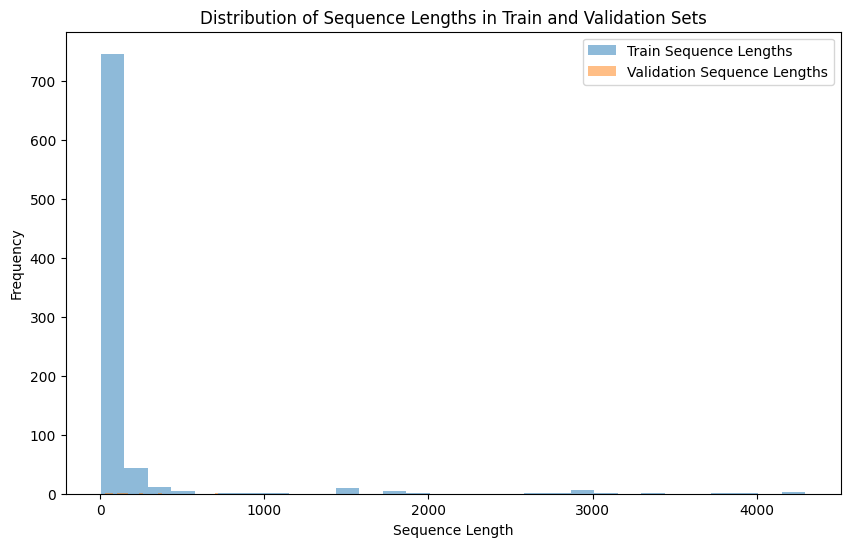

Train sequence lengths statistics:
count     844.000000
mean      162.434834
std       515.031957
min         3.000000
25%        22.000000
50%        39.500000
75%        86.000000
max      4298.000000
Name: sequence, dtype: float64
Validation sequence lengths statistics:
count     12.000000
mean     209.583333
std      194.493963
min       30.000000
25%      105.750000
50%      129.500000
75%      269.250000
max      720.000000
Name: sequence, dtype: float64


In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your training and validation datasets (adjust paths as needed)
train_sequences = pd.read_csv('/kaggle/cleaned_train_sequences2 (1).csv')
validation_sequences = pd.read_csv('/kaggle/validation_sequences.csv')

# Assuming the sequences are in a column called 'sequence' (adjust if needed)
train_lengths = train_sequences['sequence'].apply(len)
validation_lengths = validation_sequences['sequence'].apply(len)

# Plotting the sequence length distributions
plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=30, alpha=0.5, label='Train Sequence Lengths')
plt.hist(validation_lengths, bins=30, alpha=0.5, label='Validation Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths in Train and Validation Sets')
plt.legend()
plt.show()

# Basic statistics on sequence lengths
print(f"Train sequence lengths statistics:\n{train_lengths.describe()}")
print(f"Validation sequence lengths statistics:\n{validation_lengths.describe()}")


In [9]:
!pip install joblib

In [38]:
from google.colab import drive
drive.mount('/content/drive')

# Save models to Google Drive
torch.save(gcn_model.state_dict(), '/content/drive/MyDrive/gcn_model.pth')
torch.save(gat_model.state_dict(), '/content/drive/MyDrive/gat_model.pth')

print("Models saved to Google Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Models saved to Google Drive.


In [39]:
import os
print("Saved models:")
print(os.listdir('/content/'))  # This will show all files in the current directory


Saved models:
['.config', 'drive', 'sample_data']


In [41]:
# Reinitialize the models
gcn_model = GCN(input_dim=4, hidden_dim=32, output_dim=3).to(device)
gat_model = GAT(input_dim=4, hidden_dim=32, output_dim=3).to(device)

# Load the saved model state dict
gcn_model.load_state_dict(torch.load('/content/drive/MyDrive/gcn_model.pth'))
gat_model.load_state_dict(torch.load('/content/drive/MyDrive/gat_model.pth'))

# Put the models into evaluation mode
gcn_model.eval()
gat_model.eval()

print("Models loaded successfully.")


Models loaded successfully.
